## We Watch, We Listen, and We Control.

House Micaeli understands the value of knowledge, and we use our magically-enhanced powers of perception to notice secrets that no normal man would see. We have acted as detectives, inquisitors, and spy catchers, amassing power through observation.

In most cases, this has been observation of other people. A Micaeli's sharp senses can easily detect when a person is lying or pick up on a whispered conversation in a crowded marketplace. We can do this thanks to the eldritch tongue, which can be used to understand sound.

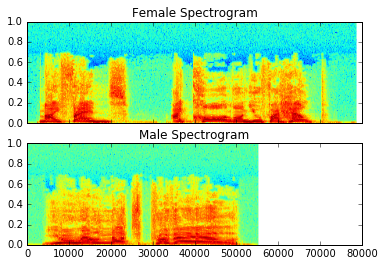

In [44]:
compare_speech()

In [51]:
%run ../../code/micaeli_setup.py ## TODO: wrap

male_human_sample = get_male_example()
female_human_sample = get_female_example()

In [49]:
listen(female_human_sample)

(You can change the above cell and re-run it to listen to the second sample.)

Micaelis can manipulate sound by representing it as a list of numbers -- indeed, sound itself is a series of pressure changes that propagates through the air. If we record a "pushing" pressure with a positive number and a "pulling" pressure with a negative number, then such a list can completely capture what your ear feels when someone speaks to you.

In [13]:
print female_human_sample

[  -4.    -2.    -6.5 ..., -120.  -110.  -112. ]


Using the Eldritch tongue, we have stored information about this woman's utterance using an identifier called a _variable_. The list of numbers (which records the pressure changes caused by the sound of her voice) has been assigned to the name `female_human_sample`. You can access individual numbers in the list using a technique called _slicing_, in which you put the number of the element you want to extract inside square brackets [] after the variable name.

In [47]:
print female_human_sample[0]

-4.0


In [48]:
print female_human_sample[1]

-2.0


One of the pecularities of the Eldritch tongue is that, to get the __first__ number in the list, you put the number __0__ inside of the brackets (and to get the second number you put 1, and so forth). It seems that the Vestiges who created this language began counting at 0 instead of 1.

__Challenge__. What you do you think slicing with the number -1 between square brackets does? Try it. Does this make sense?

A scion of House Micaeli will use the information contained in this list of numbers to learn things about the speaker; powerful barons of our house can analyze these patterns and predict the topic of conversation, how old the speaker is, and even whether the speech is truth or lie.

To perform analyses like these, you may need to walk through the entire list of numbers and do something with each one. For example, we could add up all of the numbers in the list using the Eldritch tongue like this:

In [ ]:
my_sum = 0

for number in male_human_sample:
    my_sum = my_sum + number
    
print my_sum

The line `my_sum=0` creates a new variable which is a number with the value 0. The line `for number in male_human_sample` is called a `for` loop, and tells the Eldritch tongue that whatever instructions follow it should be performed to each of the entries in the list `male_human_sample`. In this case, for each number in that list, we add the number to our variable `my_sum`. At the end of the incantation, we ask the Eldritch tongue to display the final sum using `print`.

However, computing the sum of all numbers in the list is not especially useful for predicting properties of the sound -- the positive and negative numbers in the sound cancel each other out and we lose a lot of information. 

A more interesting quantity is the __signal energy__ of a piece of audio, which measures its average volume. To find the signal energy, one adds up the *squares* of the numbers in the list, and then divides by the total length of the list. By squaring the numbers, we add contributions from both positive numbers and negative numbers, which both represent high pressures.

For example, the signal energy of the list

    [3, -2, 1]
    
is equal to `5`, since $3^2 + (-2)^2 + 1^2 = 15$, and dividing by the length of the list gives $\frac{15}{3} = 5$.

__Challenge__. Write a cell which prints out the signal energy of `male_human_sample`. You might need to use the symbol `*`, which multiplies two numbers, and the expression `len(male_human_sample)`, which gives the total length of the list.

From listening to the samples, which do you expect to have a higher signal energy? Why? Re-run your cell above to print the signal energy of `female_human_sample` and see whether your guess was right.

Often, a Micaeli can learn much more about sound by visualizing it than by looking at a raw list of numbers.

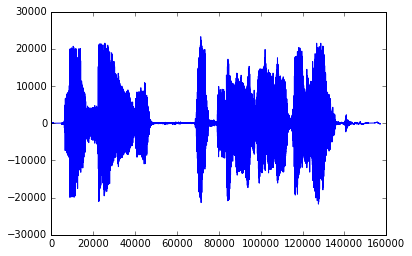

In [18]:
plot(female_human_sample)

In the Eldritch tongue, `plot` takes a list of numbers and displays a visualization which shows the size of each of the numbers with a blue line that has the corresponding height. Notice that this plot has large spikes during the parts of the audio which contain speech, and a relatively flat profile during periods of silence.

At least we can see which part of the sample is the loudest (has the highest pressure), but we can do better.

You will rightfully be impatient. Our House struggles for its very existence against the vicious aberrant invaders, while power over the City of Towers will soon change hands -- hopefully to ours.

The other barons of Micaeli have proposed a plan, and we seek your approval. Just as our House has come to power through investigating other people, learning their secrets, and using this as power, __what if we can prevail over the monstrous aberrants by observing them__? We must know our enemy, and if we can understand how these creatures communicate as well as we understand the speech of men, we will have the upper hand.

In [52]:
aberrant_example = get_aberrant_example()

## Wrap a function here to plot all three vertically with shared x

__Challenge__. Use the listen function to observe the aberrant sound.

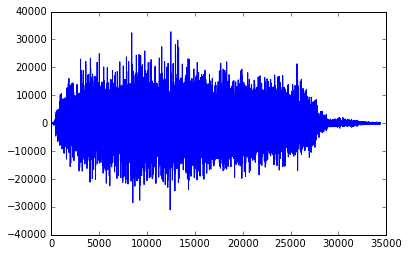

In [54]:
plot(aberrant_example)

This will be a challenge even for us. These creatures sound so different from humans!

__Brainstorm__. With the other barons of your house, brainstorm as many characteristics of sound as you can think of. What properties does sound have which might differ between men and aberrants? Feel free to include physical properties, descriptions, or whatever else comes to mind.

In [29]:
frequency_domain_demo()

Demo of how we can calculate features, including spectrogram if not done above.

Longer group challenge -- construct features from sound array. Give them examples of zero-crossing rate and energy. Ask them to think of other things and implement them. This will be scored.

First learning task -- let them listen to queen_acknowledgement1.wav and queen_annoyance3.wav. Explain the latter is annoyed. Then give them queen_annoyance2.wav. Ask them if it sounds annoyed or not? Hard to tell, but it is!

Reveal the secret -- we suspect that they're intelligent and want to try communicating with them. Want to create a translator using eldritch speech. First step is getting basic emotion, so need to use the eldritch tongue to understand whether they are angry or not. Challenge: write a program that takes in a sample of aberrant audio and outputs True if you guess it's angry, or False otherwise.

Score and show them the results. It'll probably be bad, like 0 or 1 correct. 

Probably around here the side quest will be introduced.